In [4]:
cost_0 = [1, 2, 3, 5, 2, 8, 10]
cost_1 = [10, 6, 5, 2, 1, 8, 2]
(cost_1 < cost_0)

False

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics

# --------------------- Metrics --------------------- #
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from mlxtend.evaluate import lift_score

def gini(actual, pred):
    """
    From the link:
    https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation
    """
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

# --------------------- End Metrics --------------------- #

# --------------------- Inputs --------------------- #
# ML approaches to consider
ml_names = ['knn', 'Gnb', 'LR', 'SVM', 'SVM-rbf', 'DT', 'RF', 'XGBoost']

# Sampling methods
l_sampling = ["plain", "smote", "adasyn", "tomekLinks", "ncr", "smoteRandom", "smoteTomek", "smoteNcr"]

# Datasets
dataset_name = ['Bank', 'C2C', 'DSN', 'HR', 'K2009', 'KKBox', 'Member', 'Mobile', 'SATO', 'TelC', 'TelE', 'UCI', 'news']

# Score type
score = 'auc'

# verbose
verbose = False

# Folds
n_folds = 5
# ml_auc dic
ml_auc_list = [None] * n_folds

# ------- Begin ------ #
ml_auc_list = dict()
for dataset in dataset_name:
    if verbose == True:
        print(f"---{dataset}---")
    ml_auc_list[dataset] = dict()

    for i_fold in range(1, n_folds+1):
        if verbose == True:
            print(f"fold {i_fold}")

        ml_auc_list[dataset][i_fold] = dict()
        for sampling in l_sampling:
            # Load fold results
            ml_results = pd.read_csv(f'/home/ec2-user/SageMaker/data/churn_package/churn/sampled_datasets/{dataset}/results/{dataset}_{sampling}_skf_k{i_fold}.csv', sep=';')
            y = ml_results[[f'y_{ml_names[i_fold]}']]

            ml_auc_list[dataset][i_fold][sampling] = dict()
            # For each ML, compute the AUC
            for s_ML in ml_names:
                pred = ml_results[[f'p(y=1)_{s_ML}']]
                binary_pred = ml_results[[f'yhat_{s_ML}']]
                
                if score == 'auc':
                    value_score = roc_auc_score(y, pred)
                elif score == 'f1':
                    value_score = f1_score(y, binary_pred)
                elif score == 'lift':
                    value_score = lift_score(y, binary_pred)
                elif score == 'gini':
                    value_score = gini(y, binary_pred)
                elif score == 'prauc':
                    value_score = average_precision_score(y, binary_pred)

                ml_auc_list[dataset][i_fold][sampling][s_ML] = value_score
            
            
# ---- Print results ---- #            
ml_auc_df = pd.DataFrame(ml_auc_list)

In [17]:
sampling_strat = 'smoteNcr'

appended_data = []

for dataset in dataset_name:

    appended_data.append(np.round(pd.DataFrame(pd.DataFrame(ml_auc_list[dataset]).loc[sampling_strat].tolist()).mean(),4))
    
df_sampling = pd.concat(appended_data, axis=1)
df_sampling.columns = dataset_name

# ranking
df_sampling['Rank'] = np.round(df_sampling.iloc[:, 0:13].rank(ascending=False).mean(axis=1),2)
# overall AUC
df_sampling['AUC'] = np.round(df_sampling.iloc[:, 0:13].mean(axis=1),4)
# min max distance
df_sampling.loc['Max-Min'] = df_sampling.max() - df_sampling.min()

# df_sampling.reset_index(drop=False).to_latex()

df_sampling

,Bank,C2C,DSN,HR,K2009,KKBox,Member,Mobile,SATO,TelC,TelE,UCI,news,Rank,AUC
knn,0.7781,0.4225,0.6513,0.6569,0.5003,0.6054,0.5860,0.6260,0.7053,0.7754,0.8178,0.7856,0.7495,5.23,0.6662
Gnb,0.7827,0.4963,0.6515,0.7080,0.4995,0.6485,0.5791,0.6984,0.7387,0.8176,0.7465,0.8341,0.5936,4.46,0.6765
LR,0.8320,0.5022,0.7392,0.8274,0.5153,0.6801,0.6270,0.8799,0.7575,0.8435,0.7633,0.8274,0.8388,2.23,0.7410
SVM,0.6542,0.4692,0.7334,0.7500,0.4972,0.5243,0.4485,0.6541,0.7556,0.6038,0.5954,0.5683,0.6342,6.15,0.6068
SVM-rbf,0.7773,0.4468,0.6393,0.4992,0.5044,0.4790,0.5654,0.5329,0.7138,0.7778,0.5967,0.7524,0.7010,6.23,0.6143
DT,0.7232,0.4101,0.6986,0.6620,0.4984,0.5479,0.5590,0.5825,0.6850,0.7139,0.8524,0.8537,0.7323,5.77,0.6553
RF,0.8495,0.3153,0.8556,0.7911,0.4944,0.6665,0.6218,0.6210,0.7811,0.8312,0.9364,0.9144,0.8537,3.15,0.7332
XGBoost,0.8423,0.3638,0.8661,0.8031,0.4974,0.6705,0.6125,0.6689,0.7671,0.8156,0.9413,0.9187,0.8477,2.77,0.7396
Max-Min,0.1953,0.1869,0.2268,0.3282,0.0209,0.2011,0.1785,0.3470,0.0961,0.2397,0.3459,0.3504,0.2601,4.00,0.1342


In [67]:
#df_str = df_sampling.to_csv()

## Ensemble 

In [65]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics

# --------------------- Metrics --------------------- #
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from mlxtend.evaluate import lift_score

def gini(actual, pred):
    """
    From the link:
    https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation
    """
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

# --------------------- End Metrics --------------------- #

# --------------------- Inputs --------------------- #
# ML approaches to consider
ml_names = ['LR', 'RF', 'XGBoost',  'LR|XGBoost', 'LR|XGBoost|RF']

# Sampling methods
l_sampling = ["plain", "smote", "adasyn", "tomekLinks", "ncr", "smoteRandom", "smoteTomek", "smoteNcr"]
# Datasets
dataset_name = ['Bank', 'C2C', 'DSN', 'HR', 'K2009', 'KKBox', 'Member', 'Mobile', 'SATO', 'TelC', 'TelE', 'UCI', 'news']
# Score type
score = 'auc'

# verbose
verbose = False

# Folds
n_folds = 5
# ml_auc dic
ml_auc_list = [None] * n_folds
# ensemble separator
ens_sep = '|'

# ------- Begin ------ #
ml_auc_list = dict()
for dataset in dataset_name:
    if verbose == True:
        print(f"---{dataset}---")
    ml_auc_list[dataset] = dict()

    for i_fold in range(1, n_folds+1):
        if verbose == True:
            print(f"fold {i_fold}")

        ml_auc_list[dataset][i_fold] = dict()
        for sampling in l_sampling:
            # Load fold results
            ml_results = pd.read_csv(f'/home/ec2-user/SageMaker/data/churn_package/churn/sampled_datasets/{dataset}/results/{dataset}_{sampling}_skf_k{i_fold}.csv', sep=';')
            
            y = ml_results[[f'y_{ml_names[0]}']]

            ml_auc_list[dataset][i_fold][sampling] = dict()
            # For each ML, compute the AUC
            for s_ML in ml_names:

                if s_ML.find(ens_sep) == -1:

                    pred = ml_results[[f'p(y=1)_{s_ML}']]
                    binary_pred = ml_results[[f'yhat_{s_ML}']]

                    value_score = roc_auc_score(y, pred)


                    ml_auc_list[dataset][i_fold][sampling][s_ML] = value_score
                    
                else:

                    col_names_ens = [f'p(y=1)_{ml_name}' for ml_name in s_ML.split('|')]
                    # Ens. on mean proba
                    pred = ml_results[col_names_ens].mean(axis=1)

                    value_score = roc_auc_score(y, pred)
                    
                    ml_auc_list[dataset][i_fold][sampling][s_ML] = value_score             
            
            
# ---- Print results ---- #            
ml_auc_df = pd.DataFrame(ml_auc_list)

In [66]:
sampling_strat = 'plain'

appended_data = []

for dataset in dataset_name:

    appended_data.append(np.round(pd.DataFrame(pd.DataFrame(ml_auc_list[dataset]).loc[sampling_strat].tolist()).mean(),4))
    
df_sampling = pd.concat(appended_data, axis=1)
df_sampling.columns = dataset_name

df_sampling

,Bank,C2C,DSN,HR,K2009,KKBox,Member,Mobile,SATO,TelC,TelE,UCI,news
LR,0.8322,0.5222,0.7319,0.8596,0.5135,0.6763,0.6146,0.9030,0.7594,0.8458,0.7584,0.8244,0.8369
RF,0.8506,0.3518,0.8590,0.7867,0.5114,0.6442,0.6130,0.8095,0.7882,0.8210,0.9380,0.9182,0.8615
XGBoost,0.8216,0.3862,0.8516,0.7993,0.5112,0.6800,0.5987,0.7816,0.7396,0.7983,0.9411,0.9174,0.8323
LR|XGBoost,0.8441,0.4184,0.8422,0.8549,0.5169,0.6948,0.6121,0.8675,0.7600,0.8331,0.9319,0.9199,0.8518
LR|XGBoost|RF,0.8531,0.3852,0.8623,0.8443,0.5197,0.6890,0.6201,0.8761,0.7765,0.8340,0.9435,0.9215,0.8637


## Orange - Nemenyi Plots

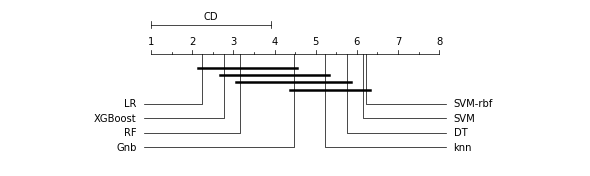

In [22]:
import io
import Orange

import matplotlib.pyplot as plt

df = pd.read_csv(io.StringIO(df_str), sep=',', engine='python')
df.index = df['Unnamed: 0']
del df['Unnamed: 0']
del df['AUC']
df = df[:-1]
df

df = df.T.copy()

names = df.columns
avranks = df.loc["Rank"]
number_of_datasets = df.shape[0] - 1
# alpha = '0.1', '0.05' or '0.01'
cd = Orange.evaluation.compute_CD(avranks,
                                  number_of_datasets,
                                  alpha='0.05',
                                  test="nemenyi"
                                 )
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=8, textspace=2)
plt.show()

## Correspondance Analysis Plot

## CosClustInfo Clustering